In [5]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator, Aer
from qiskit.providers.fake_provider import FakeProvider, FakeManila, FakeToronto, FakeJakartaV2
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter
import qiskit.quantum_info as qi
import qiskit
from qiskit.visualization import plot_histogram

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import scipy
import os
import sys
import itertools
from numpy.random import Generator, PCG64
from datetime import date
import pathlib
import inspect
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
plot_path = f'{module_path}/plots'
sys.path.insert(0, os.path.abspath('../src/'))

from feedforward import QExtremeLearningMachine
from rewinding import QRewindingRC, QRewindingStatevectorRC
from data import DataSource

# Why Statevector Simulations take so long for a growing number of qubits

- QRewindingStatevectorRC time scales nearly as 4^N
- reason: sampling counts takes long

## Individual experiments

Scroll down to experiments combined

In [6]:
from circuits import ising_circuit

shots = 2**13
nmeas = 2
nqubits_list = [*range(nmeas, 10)]
navg = 10

sv_only = True

df = pd.DataFrame()
df['nqubits'] = nqubits_list

<Axes: title={'center': 'No measurement'}, xlabel='nqubits', ylabel='time [s]'>

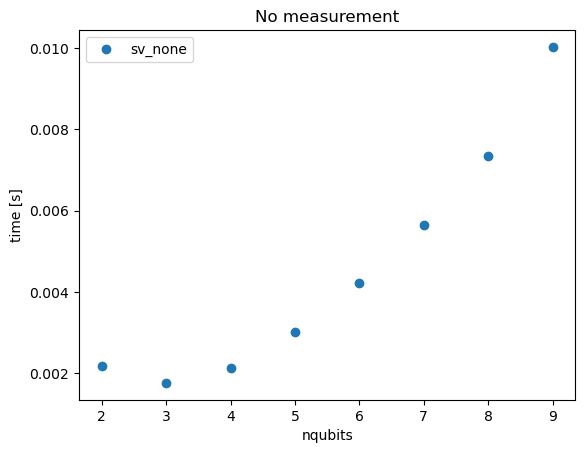

In [7]:
name = 'none'

sv_times = np.zeros(shape=(len(nqubits_list),))
dm_times = np.zeros(shape=(len(nqubits_list),))

for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)

        t0 = time.time()
        #
        statev = qi.Statevector.from_label('0'*nqubits)
        statev = statev.evolve(qc_ising)
        # counts_sv = statev.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        sv_times[cnt] += t1


        t0 = time.time()
        #
        statev_init = qi.Statevector.from_label('0'*nqubits)
        rho = qi.DensityMatrix(statev_init.data)
        rho = rho.evolve(qc_ising)
        # counts_rho = rho.sample_counts(shots=shots)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'sv_{name}'] = sv_times
df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'sv_{name}' if sv_only else [f'sv_{name}', f'dm_{name}'], 
    linestyle="none", marker="o", title='No measurement', ylabel='time [s]')

<Axes: title={'center': 'Measuring fixed number of qubits (2)'}, xlabel='nqubits', ylabel='time [s]'>

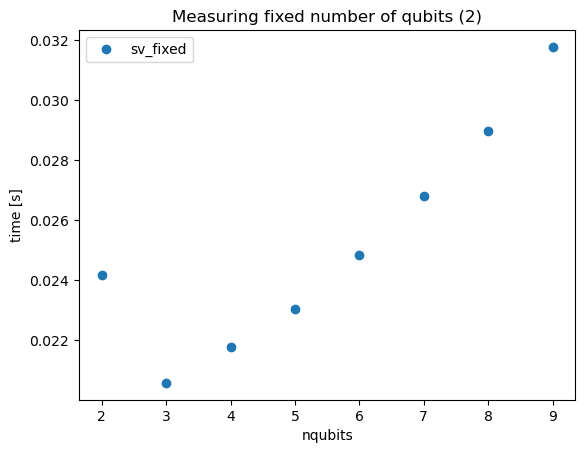

In [8]:
name = 'fixed'

sv_times = np.zeros(shape=(len(nqubits_list),))
dm_times = np.zeros(shape=(len(nqubits_list),))

qmeas = [*range(nmeas)]

for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)

        t0 = time.time()
        #
        statev = qi.Statevector.from_label('0'*nqubits)
        statev = statev.evolve(qc_ising)
        counts_sv = statev.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        sv_times[cnt] += t1


        t0 = time.time()
        #
        statev_init = qi.Statevector.from_label('0'*nqubits)
        rho = qi.DensityMatrix(statev_init.data)
        rho = rho.evolve(qc_ising)
        counts_rho = rho.sample_counts(shots=shots)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'sv_{name}'] = sv_times
df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'sv_{name}' if sv_only else [f'sv_{name}', f'dm_{name}'], 
    linestyle="none", marker="o", title='Measuring fixed number of qubits (2)', ylabel='time [s]')

<Axes: title={'center': 'Measuring a scaling number of qubits (subsystem)'}, xlabel='nqubits', ylabel='time [s]'>

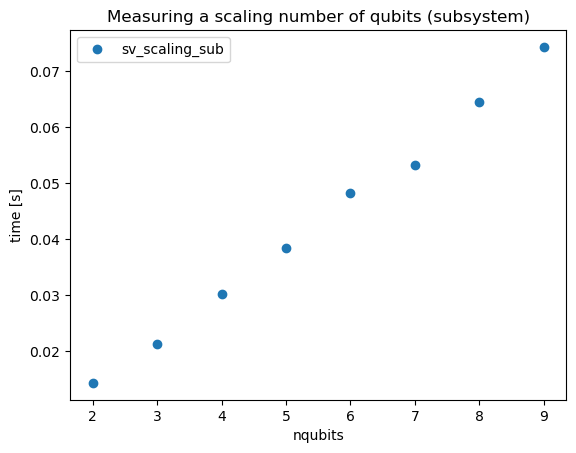

In [9]:
name = 'scaling_sub'

sv_times = np.zeros(shape=(len(nqubits_list),))
dm_times = np.zeros(shape=(len(nqubits_list),))

for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(int(nqubits - 1))]

        t0 = time.time()
        #
        statev = qi.Statevector.from_label('0'*nqubits)
        statev = statev.evolve(qc_ising)
        counts_sv = statev.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        sv_times[cnt] += t1


        t0 = time.time()
        #
        statev_init = qi.Statevector.from_label('0'*nqubits)
        rho = qi.DensityMatrix(statev_init.data)
        rho = rho.evolve(qc_ising)
        counts_rho = rho.sample_counts(shots=shots)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'sv_{name}'] = sv_times
df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'sv_{name}' if sv_only else [f'sv_{name}', f'dm_{name}'], 
    linestyle="none", marker="o", title='Measuring a scaling number of qubits (subsystem)', ylabel='time [s]')

<Axes: title={'center': 'Measuring a scaling number of qubits (all)'}, xlabel='nqubits', ylabel='time [s]'>

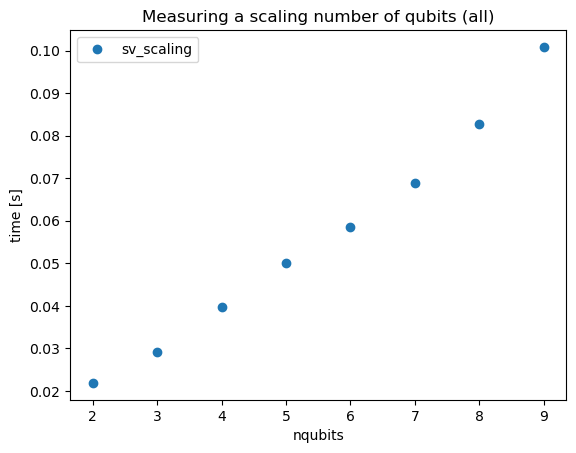

In [10]:
name = 'scaling'
sv_times = np.zeros(shape=(len(nqubits_list),))
dm_times = np.zeros(shape=(len(nqubits_list),))

for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(nqubits)]

        t0 = time.time()
        #
        statev = qi.Statevector.from_label('0'*nqubits)
        statev = statev.evolve(qc_ising)
        counts_sv = statev.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        sv_times[cnt] += t1


        t0 = time.time()
        #
        statev_init = qi.Statevector.from_label('0'*nqubits)
        rho = qi.DensityMatrix(statev_init.data)
        rho = rho.evolve(qc_ising)
        counts_rho = rho.sample_counts(shots=shots)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'sv_{name}'] = sv_times
df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'sv_{name}' if sv_only else [f'sv_{name}', f'dm_{name}'], 
    linestyle="none", marker="o", title='Measuring a scaling number of qubits (all)', ylabel='time [s]')

<Axes: title={'center': 'Measuring a scaling number of qubits (all)'}, xlabel='nqubits', ylabel='time [s]'>

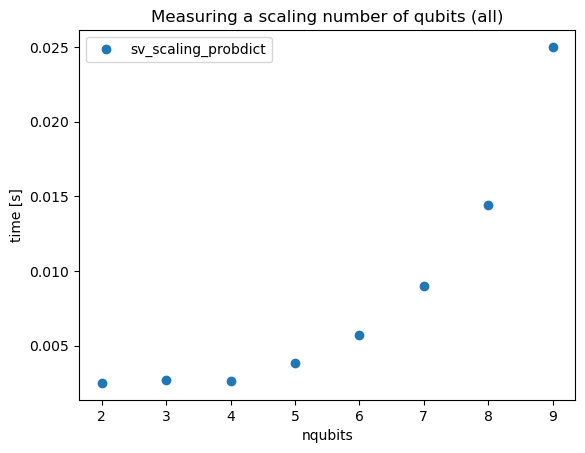

In [11]:
name = 'scaling_probdict'
sv_times = np.zeros(shape=(len(nqubits_list),))
dm_times = np.zeros(shape=(len(nqubits_list),))

for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(nqubits)]

        t0 = time.time()
        #
        statev = qi.Statevector.from_label('0'*nqubits)
        statev = statev.evolve(qc_ising)
        # counts_sv = statev.sample_counts(shots=shots, qargs=qmeas)
        probs_dict = statev.probabilities_dict()
        #
        t1 = time.time() - t0
        sv_times[cnt] += t1


        t0 = time.time()
        #
        statev_init = qi.Statevector.from_label('0'*nqubits)
        rho = qi.DensityMatrix(statev_init.data)
        rho = rho.evolve(qc_ising)
        probs_dict = rho.probabilities_dict()
        # counts_rho = rho.sample_counts(shots=shots)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'sv_{name}'] = sv_times
df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'sv_{name}' if sv_only else [f'sv_{name}', f'dm_{name}'], 
    linestyle="none", marker="o", title='Measuring a scaling number of qubits (all)', ylabel='time [s]')

<Axes: title={'center': 'Measuring a scaling number of qubits (all)'}, xlabel='nqubits', ylabel='time [s]'>

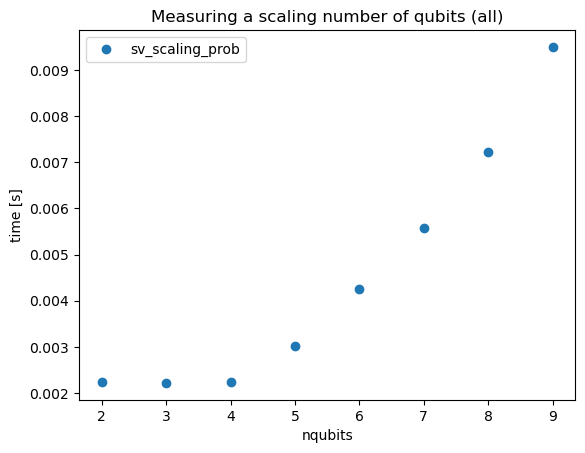

In [12]:
name = 'scaling_prob'

sv_times = np.zeros(shape=(len(nqubits_list),))
dm_times = np.zeros(shape=(len(nqubits_list),))

for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(nqubits)]

        t0 = time.time()
        #
        statev = qi.Statevector.from_label('0'*nqubits)
        statev = statev.evolve(qc_ising)
        # counts_sv = statev.sample_counts(shots=shots, qargs=qmeas)
        probs = statev.probabilities()
        #
        t1 = time.time() - t0
        sv_times[cnt] += t1


        t0 = time.time()
        #
        statev_init = qi.Statevector.from_label('0'*nqubits)
        rho = qi.DensityMatrix(statev_init.data)
        rho = rho.evolve(qc_ising)
        probs = rho.probabilities()
        # counts_rho = rho.sample_counts(shots=shots)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'sv_{name}'] = sv_times
df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'sv_{name}' if sv_only else [f'sv_{name}', f'dm_{name}'], 
    linestyle="none", marker="o", title='Measuring a scaling number of qubits (all)', ylabel='time [s]')

<Axes: title={'center': 'Measuring a scaling number of qubits (all)'}, xlabel='nqubits', ylabel='time [s]'>

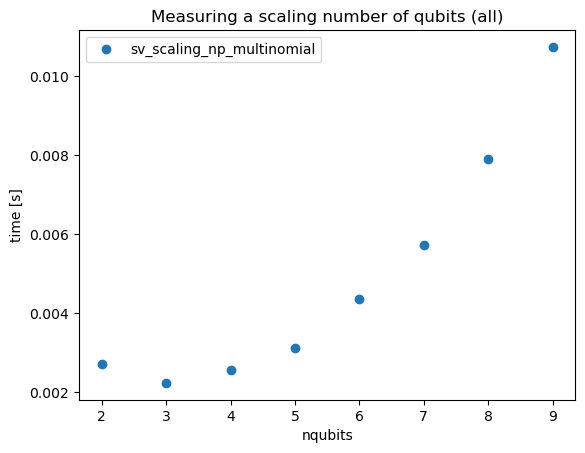

In [13]:
name = 'scaling_np_multinomial'
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html

sv_times = np.zeros(shape=(len(nqubits_list),))
dm_times = np.zeros(shape=(len(nqubits_list),))

for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(nqubits)]

        t0 = time.time()
        #
        statev = qi.Statevector.from_label('0'*nqubits)
        statev = statev.evolve(qc_ising)
        # counts_sv = statev.sample_counts(shots=shots, qargs=qmeas)
        probs = statev.probabilities() # (2^N,)
        counts_mn = np.random.multinomial(n=shots, pvals=probs) 
        counts = {format(i, "b").zfill(nqubits): c for i, c in enumerate(counts_mn)} 
        # counts = {format(i, "b").zfill(nqubits)[::-1]: c for i, c in enumerate(counts_mn)} 
        #
        t1 = time.time() - t0
        sv_times[cnt] += t1


        t0 = time.time()
        #
        statev_init = qi.Statevector.from_label('0'*nqubits)
        rho = qi.DensityMatrix(statev_init.data)
        rho = rho.evolve(qc_ising)
        probs = rho.probabilities()
        counts_mn = np.random.multinomial(n=shots, pvals=probs) 
        counts = {format(i, "b").zfill(nqubits): c for i, c in enumerate(counts_mn)} 
        # counts = {format(i, "b").zfill(nqubits)[::-1]: c for i, c in enumerate(counts_mn)} 
        # counts_rho = rho.sample_counts(shots=shots)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'sv_{name}'] = sv_times
df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'sv_{name}' if sv_only else [f'sv_{name}', f'dm_{name}'], 
    linestyle="none", marker="o", 
    title='Measuring a scaling number of qubits (all)', ylabel='time [s]',
)

In [14]:
print(counts_sv)
print(counts_sv['000000000'])

print(counts)
print(counts['000000000'])

{'000000000': 193, '000000011': 6, '000000101': 47, '000000110': 116, '000001001': 191, '000001010': 110, '000001100': 2, '000001111': 44, '000010001': 316, '000010010': 237, '000010100': 19, '000010111': 13, '000011000': 17, '000011011': 7, '000011101': 13, '000011110': 61, '000100001': 92, '000100010': 68, '000100100': 32, '000100111': 6, '000101000': 10, '000101011': 3, '000101101': 64, '000101110': 31, '000110000': 149, '000110011': 145, '000110101': 23, '000110110': 22, '000111010': 21, '000111100': 4, '000111111': 26, '001000001': 70, '001000010': 68, '001000100': 90, '001000111': 120, '001001000': 174, '001001011': 192, '001001101': 29, '001001110': 1, '001010000': 32, '001010011': 27, '001010101': 66, '001010110': 20, '001011001': 30, '001011010': 101, '001011100': 30, '001011111': 9, '001100000': 25, '001100011': 35, '001100101': 6, '001100110': 44, '001101001': 50, '001101010': 4, '001101100': 26, '001101111': 15, '001110001': 18, '001110010': 17, '001110100': 1, '001110111':

In [15]:
# {format(key, "b").zfill(n): value for key, value in self.items()}

In [16]:
def bin_list(n, reversed=False):
    if reversed:
        return reversed([format(i, "b").zfill(n) for i in range(2**n)])
    else:
        return [format(i, "b").zfill(n) for i in range(2**n)]

# bin_list(5)

In [17]:
df

,nqubits,sv_none,dm_none,sv_fixed,dm_fixed,sv_scaling_sub,dm_scaling_sub,sv_scaling,dm_scaling,sv_scaling_probdict,dm_scaling_probdict,sv_scaling_prob,dm_scaling_prob,sv_scaling_np_multinomial,dm_scaling_np_multinomial
0,2,0.002185,0.002038,0.024178,0.023165,0.014291,0.021333,0.021876,0.021892,0.002501,0.001995,0.002237,0.001847,0.002718,0.002348
1,3,0.001760,0.002382,0.020578,0.030668,0.021244,0.032208,0.029242,0.030488,0.002722,0.002971,0.002219,0.002660,0.002238,0.003109
2,4,0.002132,0.003961,0.021783,0.042900,0.030134,0.041639,0.039825,0.041018,0.002640,0.005164,0.002230,0.004168,0.002556,0.004421
3,5,0.003010,0.012358,0.023055,0.060885,0.038349,0.059308,0.049968,0.060171,0.003832,0.010544,0.003011,0.011290,0.003109,0.010693
4,6,0.004221,0.040856,0.024842,0.097184,0.048153,0.099131,0.058409,0.098063,0.005677,0.045458,0.004244,0.041707,0.004362,0.036622
5,7,0.005638,0.145597,0.026818,0.216683,0.053219,0.200842,0.068759,0.222587,0.008983,0.158094,0.005578,0.144422,0.005723,0.140020
6,8,0.007350,0.644809,0.028971,0.741003,0.064471,0.709654,0.082708,0.746716,0.014433,0.645470,0.007225,0.631836,0.007892,0.630890
7,9,0.010030,3.338692,0.031784,3.534843,0.074343,3.300609,0.100854,3.405244,0.024993,3.190664,0.009497,3.116294,0.010730,3.223743


## Experiments combined

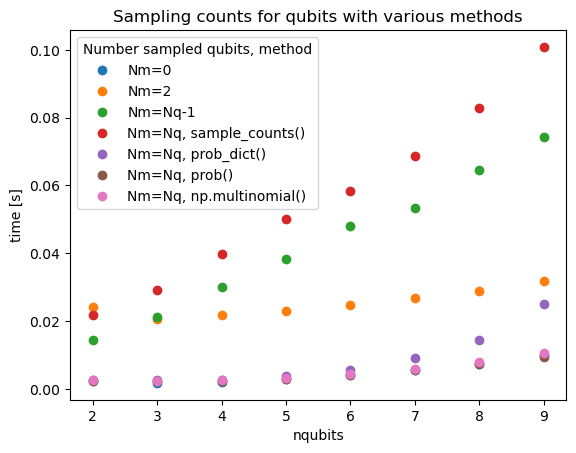

In [42]:
ax = df.plot(
    x='nqubits', 
    y=[p for p in df.columns.tolist() if p[:2] == 'sv'] if sv_only else [p for p in df.columns.tolist() if p not in ['nqubits']], 
    linestyle="none", marker="o", 
    title='Sampling counts for qubits with various methods', ylabel='time [s]',
)
ax.legend(
    title='Number sampled qubits, method',
    labels=['Nm=0', 'Nm=2', 'Nm=Nq-1', 'Nm=Nq, sample_counts()', 'Nm=Nq, prob_dict()', 'Nm=Nq, prob()', 'Nm=Nq, np.multinomial()'],
)

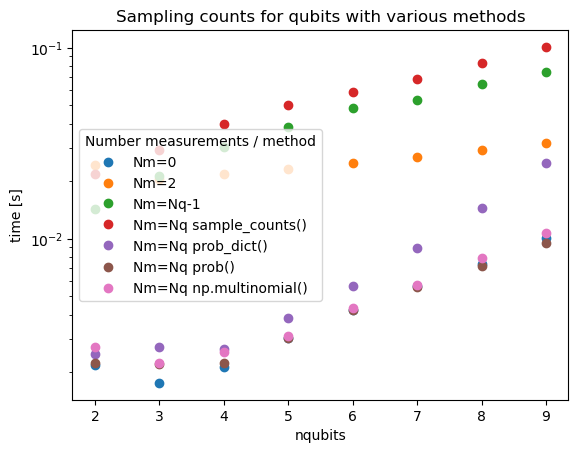

In [38]:
ax = df.plot(
    x='nqubits', 
    y=[p for p in df.columns.tolist() if p[:2] == 'sv'] if sv_only else [p for p in df.columns.tolist() if p not in ['nqubits']], 
    linestyle="none", marker="o", 
    title='Sampling counts for qubits with various methods', ylabel='time [s]',
    logy=True,
)
ax.legend(
    title='Number measurements / method',
    labels=['Nm=0', 'Nm=2', 'Nm=Nq-1', 'Nm=Nq sample_counts()', 'Nm=Nq prob_dict()', 'Nm=Nq prob()', 'Nm=Nq np.multinomial()'],
)

### DM

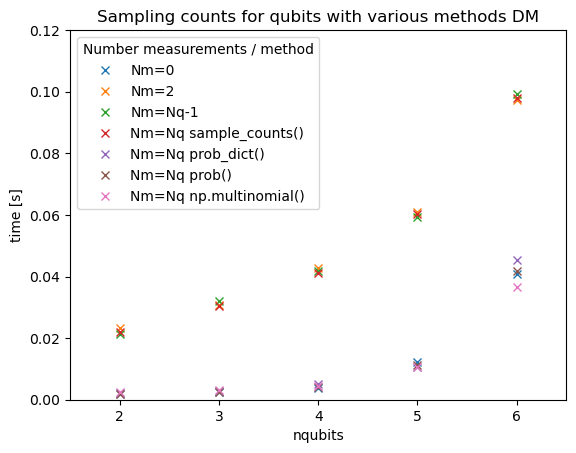

In [57]:
ax = df.plot(
    x='nqubits', 
    y=[p for p in df.columns.tolist() if p[:2] == 'dm'], 
    linestyle="none", marker="x", 
    title='Sampling counts for qubits with various methods DM', ylabel='time [s]',
    xlim=[1.5, 6.5],
    ylim=[0, 0.12]
)
ax.legend(
    title='Number measurements / method',
    labels=['Nm=0', 'Nm=2', 'Nm=Nq-1', 'Nm=Nq sample_counts()', 'Nm=Nq prob_dict()', 'Nm=Nq prob()', 'Nm=Nq np.multinomial()'],
)

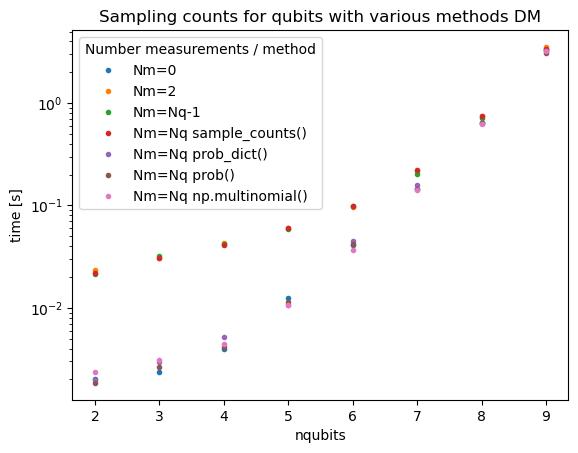

In [61]:
ax = df.plot(
    x='nqubits', 
    y=[p for p in df.columns.tolist() if p[:2] == 'dm'], 
    linestyle="none", marker=".", 
    title='Sampling counts for qubits with various methods DM', ylabel='time [s]',
    logy=True,
)
ax.legend(
    title='Number measurements / method',
    labels=['Nm=0', 'Nm=2', 'Nm=Nq-1', 'Nm=Nq sample_counts()', 'Nm=Nq prob_dict()', 'Nm=Nq prob()', 'Nm=Nq np.multinomial()'],
)

In [20]:
# ax = df.plot.scatter(x='nqubits', y='sv')
# ax = df.plot.scatter(x='nqubits', y='dm', ax=ax)